#Fake News detection

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pickle
import warnings
import ssl
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryanshelke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aryanshelke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###Load Dataset

In [2]:
df_true = pd.read_csv('data/True.csv')
df_fake = pd.read_csv('data/Fake.csv')
df_true.shape, df_fake.shape

((21417, 4), (23481, 4))

###Drop columns "subject" and "subject". Add column "label"

In [3]:
df_true.drop(['subject', 'date'], axis=1, inplace=True)
df_fake.drop(['subject', 'date'], axis=1, inplace=True)
df_true['label'] = 1
df_fake['label'] = 0
df_true.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


###Merge True and Fake dataset

In [4]:
df = pd.concat([df_true,df_fake]).sample(frac=1).reset_index(drop=True)
print(df.shape)
df.head()

(44898, 3)


,title,text,label
0,A DEFENSIVE JOHN KERRY Asks That Israel Move I...,John Kerry gave a long-winded speech today cla...,0
1,Vatican vows to seek truth about diplomat in c...,"ROME (Reuters) - The Vatican, at the start of ...",1
2,NOT EVERY HOLLYWOOD ACTOR Approved Of Meryl St...,Thank goodness there are still a few courageou...,0
3,Sean Hannity Throws Hissy Fit After Real Repo...,"Just like Donald Trump, Sean Hannity has a thi...",0
4,"At Trump's Cabinet meeting, flattery is flavor...",WASHINGTON (Reuters) - They came to praise Pre...,1


###Data preprocessing

In [5]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)
df['text'] = df['text'].apply(preprocess_text)

###Feature Extraction

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['text'])
y = df['label']

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model training

In [8]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
# Predict on the test set
y_pred = model.predict(X_test)
print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Logistic Regression Performance:
Accuracy: 0.9872

Classification Report:
              precision    recall  f1-score   support

           0     0.9891    0.9863    0.9877      4680
           1     0.9852    0.9881    0.9866      4300

    accuracy                         0.9872      8980
   macro avg     0.9871    0.9872    0.9872      8980
weighted avg     0.9872    0.9872    0.9872      8980



In [9]:
with open('models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

###Deploy

In [12]:
def detectNews(text):
    with open('models/logistic_regression_model.pkl', 'rb') as f:
        model = pickle.load(f)
        
    with open('models/tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)

    """Classify news text as Real or Fake."""
    processed_text = preprocess_text(text)
    text_vector = vectorizer.transform([processed_text])
    prediction = model.predict(text_vector)
    probability = model.predict_proba(text_vector)

    label = "Real News" if prediction[0] == 1 else "Fake News"
    confidence = probability[0][prediction[0]]

    return label, confidence

In [13]:

sample_text = "hello world"
result, confidence = detectNews(sample_text)
print(f"Result: {result} with confidence: {confidence:.2f}")

Result: Fake News with confidence: 0.96


###Check for null values

In [14]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

###Check for duplicated values

In [15]:
df.duplicated().sum()

np.int64(5921)

In [16]:
df.drop_duplicates(inplace=True)

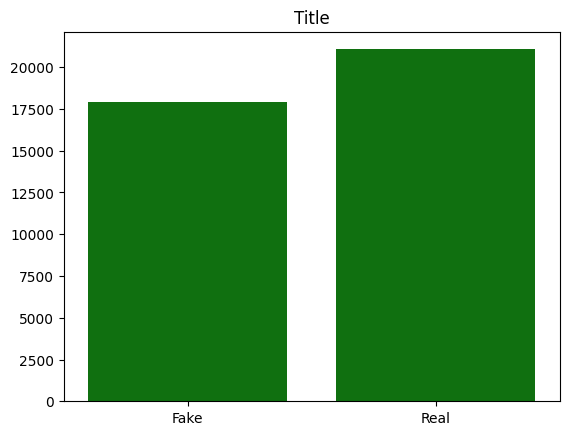

In [17]:
sns.countplot(x='label', data=df, color='g')
plt.title("Title")
plt.xlabel("")
plt.ylabel("")
plt.xticks([1,0], ['Real', 'Fake'])
plt.show()

#References:
1. https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data
